In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import glob
import os
import pandas as pd
import netCDF4
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
regrid_files = sorted(glob.glob("/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.202308*.nc"))
print(regrid_files)

['/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023080118.5deg.ll.nc', '/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023080218.5deg.ll.nc', '/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023080318.5deg.ll.nc', '/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023080418.5deg.ll.nc', '/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023080518.5deg.ll.nc', '/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023080618.5deg.ll.nc', '/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023080718.5deg.ll.nc', '/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023080818.5deg.ll.nc', '/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023080918.5deg.ll.nc', '/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023081018.5deg.ll.nc', '/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023081118.5deg.ll.nc', '/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/tracer.2023081218.5deg.ll.nc', '/home/alubianashari/18Z_RA

In [5]:
import os
import glob
import shutil
from datetime import datetime

# Input and output paths
tempo_dir = "/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/"
tempo_files = sorted(glob.glob(os.path.join(tempo_dir, "TEMPO_NO2_L3_V03_202308*T*.nc")))

nearest_dir = "/home/alubianashari/Nearest18Z_TEMPO"
os.makedirs(nearest_dir, exist_ok=True)

# Group TEMPO files by date
tempo_by_date = {}
for f in tempo_files:
    fname = os.path.basename(f)
    timestr = fname.split('_')[4]  # '20230831T172224Z'
    date = timestr[:8]            # '20230831'
    tempo_by_date.setdefault(date, []).append(f)

# Extract datetime from filename
def extract_time(f):
    fname = os.path.basename(f)
    timestr = fname.split('_')[4]  # '20230831T172224Z'
    return datetime.strptime(timestr, "%Y%m%dT%H%M%SZ")

# Loop through each day and copy the closest scan to 18Z
for date, file_list in tempo_by_date.items():
    target_time = datetime.strptime(date + "18", "%Y%m%d%H")  # target = 18Z
    file_list.sort(key=lambda f: abs(extract_time(f) - target_time))
    best_file = file_list[0]

    dst = os.path.join(nearest_dir, os.path.basename(best_file))
    shutil.copy(best_file, dst)

In [8]:
# Paths
raqms_dir = "/home/alubianashari/18Z_RAQMS_Regridded_TEMPO_nc/"
tempo_dir = "/home/alubianashari/Nearest18Z_TEMPO/"
output_dir = "18Z_RAQMS_TEMPO_Final_Fig"
save_dir = "/home/alubianashari/18Z_RAQMS_CloudMasked_TEMPO/"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

# Load RAQMS files
regrid_files = sorted(glob.glob(f"{raqms_dir}/tracer.202308*.nc"))
daily_files = {}
for f in regrid_files:
    filename = os.path.basename(f)
    date_str = filename.split('.')[1][:8]
    daily_files.setdefault(date_str, []).append(f)

# Process each day
for date, day_files in daily_files.items():
    print(f"\nProcessing {date}...")

    # Load RAQMS 18Z regridded files   
    raqms_file = day_files[0]  
    ds = xr.open_dataset(raqms_file)
    no2_18z = ds["no2tot"].values
    lat = ds["latitude"].values
    lon = ds["longitude"].values

    # Load TEMPO files
    tempo_pattern = f"{tempo_dir}/TEMPO_NO2_L3_V03_{date}T*.nc"
    tempo_files = glob.glob(tempo_pattern)
    if not tempo_files:
        print(f"  No TEMPO files found for {date}, skipping.")
        continue

    tempo_path = tempo_files[0]
    try:
        ds_prod = xr.open_dataset(tempo_path, group="product")
        ds_supp = xr.open_dataset(tempo_path, group="support_data")

        flag = ds_prod['main_data_quality_flag'].squeeze()
        cloud = ds_supp['eff_cloud_fraction'].squeeze()
        tempo_no2 = (ds_prod['vertical_column_troposphere'] + ds_prod['vertical_column_stratosphere']).squeeze() / 1e16

        # Valid TEMPO pixels
        valid = (flag == 0) & (cloud < 0.15)
        raqms_masked = np.where(valid, no2_18z, np.nan)
        tempo_masked = tempo_no2.where(valid)

    except Exception as e:
        print(f"Failed to process TEMPO for {date}: {e}")
        continue

    # Plotting
    fig = plt.figure(figsize=(10, 6), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-145, -35, 15, 65], crs=ccrs.PlateCarree())

    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    ax.add_feature(cf.STATES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.4)

    ax.set_xticks(np.arange(-140, -30 + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(20, 60 + 1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))

    mesh = ax.pcolormesh(lon, lat, raqms_masked, cmap='gist_stern_r', vmin=0, vmax=3, shading='auto', transform=ccrs.PlateCarree())
    plt.colorbar(mesh, orientation='horizontal', label='RAQMS Total Column NO₂ (10¹⁶ molecules/cm²)', fraction=0.046, pad=0.1)

    ax.set_title(f"RAQMS NO₂ @18Z (Masked by TEMPO {os.path.basename(tempo_path)[24:39]})")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/RAQMS_CloudMasked_{date}.png", facecolor='white', bbox_inches='tight')
    plt.close()

    # save
    out_ds = xr.Dataset(
        {
            "no2_18z": (["lat", "lon"], no2_18z),
            "no2_masked": (["lat", "lon"], raqms_masked),
            "tempo_no2": (["lat", "lon"], tempo_masked.data),
        },
        coords={"lat": lat, "lon": lon}
    )
    out_ds.to_netcdf(f"{save_dir}/RAQMS_TEMPO_{date}.nc")
    print(f"Saved NetCDF for {date}")



Processing 20230801...
  No TEMPO files found for 20230801, skipping.

Processing 20230802...
Saved NetCDF for 20230802

Processing 20230803...
  No TEMPO files found for 20230803, skipping.

Processing 20230804...
Saved NetCDF for 20230804

Processing 20230805...
Saved NetCDF for 20230805

Processing 20230806...
Saved NetCDF for 20230806

Processing 20230807...
Saved NetCDF for 20230807

Processing 20230808...
Saved NetCDF for 20230808

Processing 20230809...
Saved NetCDF for 20230809

Processing 20230810...
  No TEMPO files found for 20230810, skipping.

Processing 20230811...
Saved NetCDF for 20230811

Processing 20230812...
Saved NetCDF for 20230812

Processing 20230813...
  No TEMPO files found for 20230813, skipping.

Processing 20230814...
  No TEMPO files found for 20230814, skipping.

Processing 20230815...
Saved NetCDF for 20230815

Processing 20230816...
Saved NetCDF for 20230816

Processing 20230817...
Saved NetCDF for 20230817

Processing 20230818...
Saved NetCDF for 2023

In [10]:

# Check the output files
file_path = "/home/alubianashari/18Z_RAQMS_CloudMasked_TEMPO/RAQMS_TEMPO_20230815.nc"

# Open the dataset
ds = xr.open_dataset(file_path)

# Print summary
print(ds)


<xarray.Dataset> Size: 366MB
Dimensions:     (lat: 2950, lon: 7750)
Coordinates:
  * lat         (lat) float32 12kB 14.01 14.03 14.05 14.07 ... 72.95 72.97 72.99
  * lon         (lon) float32 31kB -168.0 -168.0 -167.9 ... -13.05 -13.03 -13.01
Data variables:
    no2_18z     (lat, lon) float32 91MB ...
    no2_masked  (lat, lon) float32 91MB ...
    tempo_no2   (lat, lon) float64 183MB ...


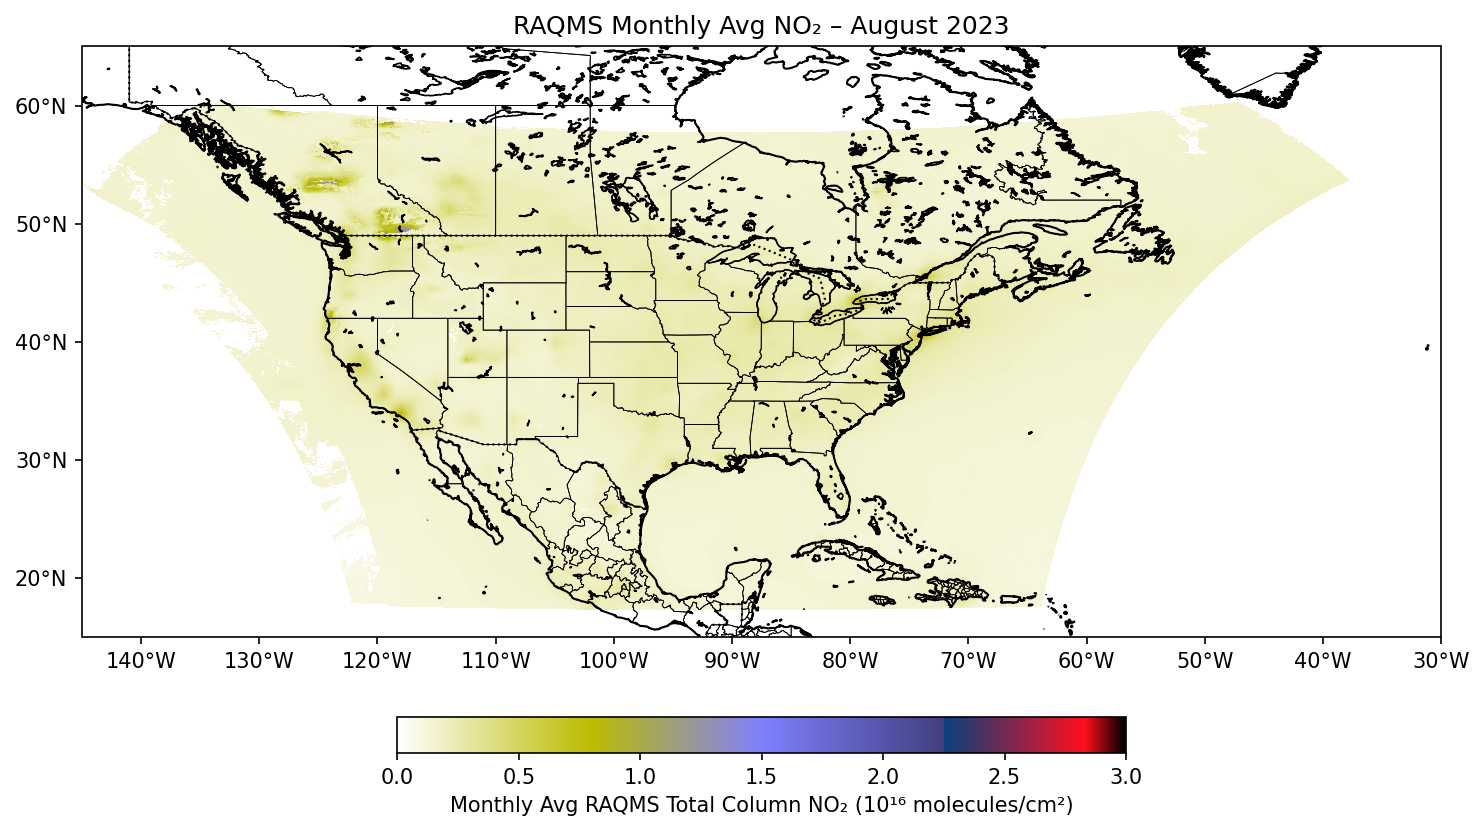

Included dates:
RAQMS_TEMPO_20230802.nc
RAQMS_TEMPO_20230804.nc
RAQMS_TEMPO_20230805.nc
RAQMS_TEMPO_20230806.nc
RAQMS_TEMPO_20230807.nc
RAQMS_TEMPO_20230808.nc
RAQMS_TEMPO_20230809.nc
RAQMS_TEMPO_20230811.nc
RAQMS_TEMPO_20230812.nc
RAQMS_TEMPO_20230815.nc
RAQMS_TEMPO_20230816.nc
RAQMS_TEMPO_20230817.nc
RAQMS_TEMPO_20230818.nc
RAQMS_TEMPO_20230819.nc
RAQMS_TEMPO_20230820.nc
RAQMS_TEMPO_20230821.nc
RAQMS_TEMPO_20230822.nc
RAQMS_TEMPO_20230825.nc
RAQMS_TEMPO_20230826.nc
RAQMS_TEMPO_20230828.nc
RAQMS_TEMPO_20230829.nc
RAQMS_TEMPO_20230830.nc
RAQMS_TEMPO_20230831.nc


In [ ]:
# RAQMS Monthly Average Plot, excluding specific dates
# Load files
data_dir = "/home/alubianashari/18Z_RAQMS_CloudMasked_TEMPO/"
exclude_dates = ["20230823", "20230827"]
files = sorted(glob.glob(os.path.join(data_dir, "RAQMS_TEMPO_202308*.nc")))
files = [f for f in files if not any(date in f for date in exclude_dates)]

# Open and stack daily data
data_list = []
for f in files:
    ds = xr.open_dataset(f)
    data_list.append(ds["no2_masked"])

stacked = xr.concat(data_list, dim="time")

# Compute monthly mean
monthly_avg = stacked.mean(dim="time", skipna=True)
lat = ds["lat"]
lon = ds["lon"]

# Plotting
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-145, -35, 15, 65], crs=ccrs.PlateCarree())

ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
ax.add_feature(cf.STATES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.4)

ax.set_xticks(np.arange(-140, -30 + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(20, 60 + 1, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))

mesh = ax.pcolormesh(lon, lat, monthly_avg, transform=ccrs.PlateCarree(),
                     cmap='gist_stern_r', vmin=0, vmax=3, shading='auto')
plt.colorbar(mesh, orientation='horizontal',
             label='Monthly Avg RAQMS Total Column NO₂ (10¹⁶ molecules/cm²)',
             fraction=0.046, pad=0.1)

ax.set_title("RAQMS Monthly Avg NO₂ – August 2023")
plt.tight_layout()
plt.savefig("monthly_avg_TEMPO/RAQMS_MonthlyAvg_Aug2023_v2.png", facecolor='white', bbox_inches='tight')
plt.show()

print("Included dates:")
for f in files:
    print(os.path.basename(f))

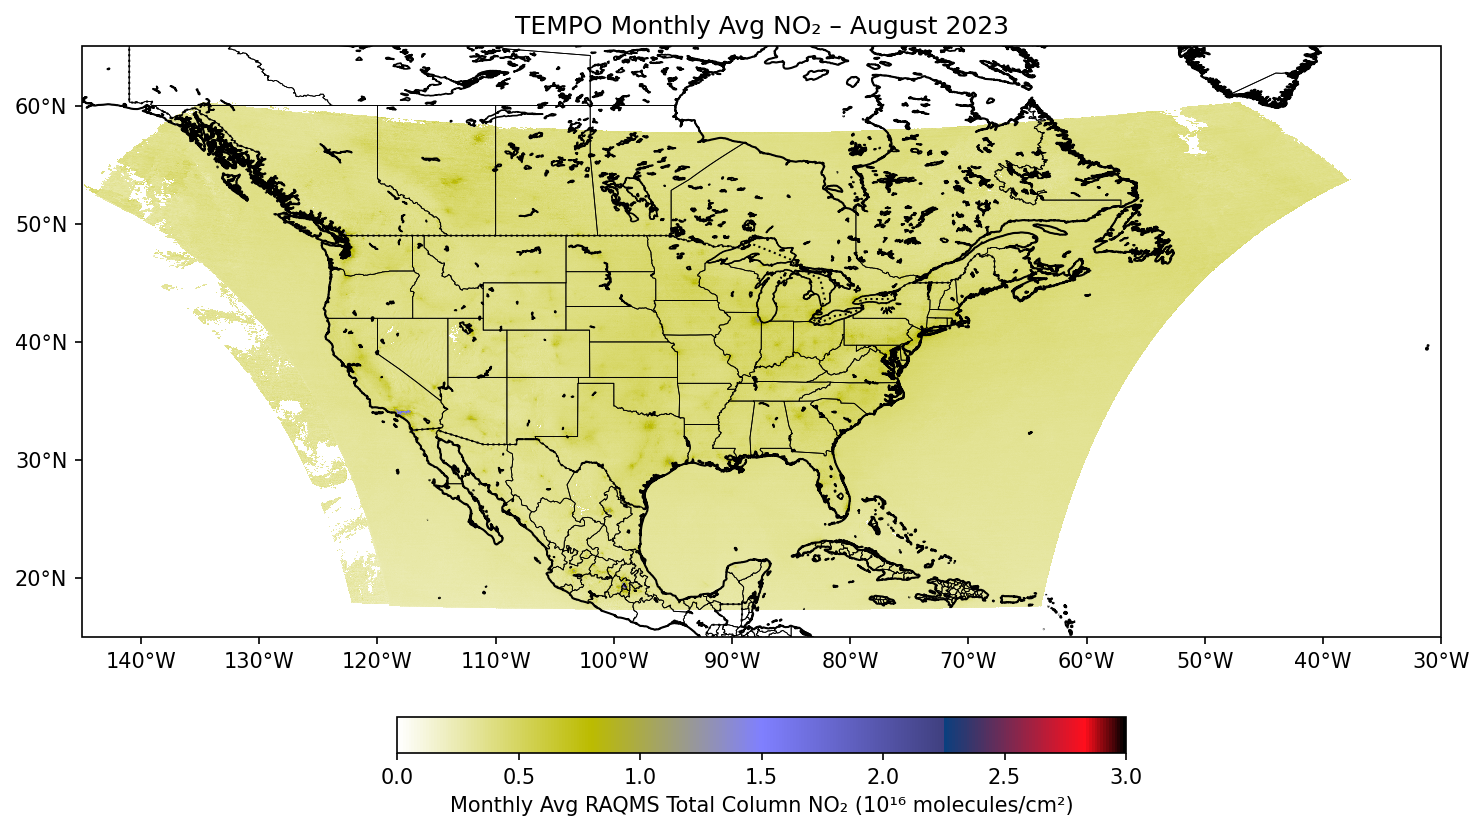

In [6]:
# TEMPO Monthly Average Plot
# Load files
data_dir = "/home/alubianashari/RAQMS_CloudMasked_TEMPO/"
files = sorted(glob.glob(os.path.join(data_dir, "RAQMS_TEMPO_202308*.nc")))
exclude_dates = ["20230823", "20230827"]
files = [f for f in files if not any(date in f for date in exclude_dates)]

# Open and stack daily data
data_list = []
for f in files:
    ds = xr.open_dataset(f)
    data_list.append(ds["tempo_no2_avg"])

stacked = xr.concat(data_list, dim="time")

# Compute monthly mean
monthly_avg = stacked.mean(dim="time", skipna=True)
lat = ds["lat"]
lon = ds["lon"]

# Plotting
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-145, -35, 15, 65], crs=ccrs.PlateCarree())

ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
ax.add_feature(cf.STATES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.4)

ax.set_xticks(np.arange(-140, -30 + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(20, 60 + 1, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))

mesh = ax.pcolormesh(lon, lat, monthly_avg, transform=ccrs.PlateCarree(),
                     cmap='gist_stern_r', vmin=0, vmax=3, shading='auto')
plt.colorbar(mesh, orientation='horizontal',
             label='Monthly Avg RAQMS Total Column NO₂ (10¹⁶ molecules/cm²)',
             fraction=0.046, pad=0.1)

ax.set_title("TEMPO Monthly Avg NO₂ – August 2023")
plt.tight_layout()
plt.savefig("monthly_avg_TEMPO/TEMPO_MonthlyAvg_Aug2023_v2.png", facecolor='white', bbox_inches='tight')
plt.show()